# Introduction

In this project I will demonstrate how to build a model predicting readmission for patients with diabetes in Python using the following steps
- data exploration
- feature engineering
- building training/validation/test samples
- model selection
- model evaluation

# Project Definition

Predict if a patient with diabetes will be readmitted to the hospital within 30 days. 

# Data set exploration

The data that is used in this project originally comes from the UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008). The data consists of over 100000 hospital admissions from patients with diabetes from 130 US hospitals between 1999-2008. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# load the csv file
df = pd.read_csv('diabetic_data.csv')

In [3]:
print('Number of samples:',len(df))

Number of samples: 101766


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

The most important column here is `readmitted`, which tells us if a patient was hospitalized within 30 days, greater than 30 days or not readmitted. 

In [5]:
# count the number of rows for each type
df.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

Another column that is important is `discharge_disposition_id`, which tells us where the patient went after the hospitalization.

In [6]:
df.groupby('discharge_disposition_id').size()

discharge_disposition_id
1     60234
2      2128
3     13954
4       815
5      1184
6     12902
7       623
8       108
9        21
10        6
11     1642
12        3
13      399
14      372
15       63
16       11
17       14
18     3691
19        8
20        2
22     1993
23      412
24       48
25      989
27        5
28      139
dtype: int64

In [7]:
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

Now let's define an output variable for our binary classification. Here we will try to predict if a patient is likely to be re-admitted within 30 days of discharge.

In [8]:
df['OUTPUT_LABEL'] = (df.readmitted == '<30').astype('int')

Let's define a function to calculate the prevalence of population that is readmitted with 30 days. 

In [9]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [10]:
print('Prevalence:%.3f'%calc_prevalence(df['OUTPUT_LABEL'].values))

Prevalence:0.114


Around 11% of the population is rehospitalized. This represented an imbalanced classification problem so we will address that below. 

In [11]:
print('Number of columns:',len(df.columns))

Number of columns: 51


From analysis of the columns, we can see there are a mix of categorical (non-numeric) and numerical data. A few things to point out, 

    - encounter_id and patient_nbr: these are just identifiers and not useful variables
    - age and weight: are categorical in this data set
    - admission_type_id,discharge_disposition_id,admission_source_id: are numerical here, but are IDs (see IDs_mapping). They should be considered categorical. 
    - examide and citoglipton only have 1 value, so we will not use these variables
    - diag1, diag2, diag3 - are categorical and have a lot of values. We will not use these as part of this project, but you could group these ICD codes to reduce the dimension. We will use number_diagnoses to capture some of this information. 
    - medical_speciality - has many categorical variables, so we should consider this when making features. 

# Feature Engineering

In [12]:
# replace ? with nan
df = df.replace('?',np.nan)

## Numerical Features

In [13]:
cols_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

In [14]:
df[cols_num].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

## Categorical Features

In [15]:
cols_cat = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

In [16]:
df[cols_cat].isnull().sum()

race                         2234
gender                          0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
payer_code                  39398
dtype: int64

`race`, `payer_code`, and `medical_specialty` have missing data. Since these are categorical data, the best thing to do is to just add another categorical type for unknown using the `fillna` function. 

In [17]:
df['race'] = df['race'].fillna('UNK')
df['payer_code'] = df['payer_code'].fillna('UNK')
df['medical_specialty'] = df['medical_specialty'].fillna('UNK')

Let's investigate medical specialty before we begin. 

In [18]:
print('Number medical specialty:', df.medical_specialty.nunique())
df.groupby('medical_specialty').size().sort_values(ascending = False)

Number medical specialty: 73


medical_specialty
UNK                                  48616
InternalMedicine                     14237
Emergency/Trauma                      7419
Family/GeneralPractice                7252
Cardiology                            5279
Surgery-General                       3059
Nephrology                            1539
Orthopedics                           1392
Orthopedics-Reconstructive            1230
Radiologist                           1121
Pulmonology                            854
Psychiatry                             853
Urology                                682
ObstetricsandGynecology                669
Surgery-Cardiovascular/Thoracic        642
Gastroenterology                       538
Surgery-Vascular                       525
Surgery-Neuro                          462
PhysicalMedicineandRehabilitation      391
Oncology                               319
Pediatrics                             253
Neurology                              201
Hematology/Oncology                 

We can see that most of them are unknown and that the count drops off pretty quickly. We don't want to add 73 new variables since some of them only have a few samples. As an alternative, we can create a new variable that only has 11 options (the top 10 specialities and then an other category). Obviously, there are other options for bucketing, but this is one of the easiest methods. 

In [19]:
top_10 = ['UNK','InternalMedicine','Emergency/Trauma',\
          'Family/GeneralPractice', 'Cardiology','Surgery-General' ,\
          'Nephrology','Orthopedics',\
          'Orthopedics-Reconstructive','Radiologist']

# make a new column with duplicated data
df['med_spec'] = df['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
df.loc[~df.med_spec.isin(top_10),'med_spec'] = 'Other'

In [20]:
df.groupby('med_spec').size()

med_spec
Cardiology                     5279
Emergency/Trauma               7419
Family/GeneralPractice         7252
InternalMedicine              14237
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Other                          8199
Radiologist                    1121
Surgery-General                3059
UNK                           48616
dtype: int64

In [21]:
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

df[cols_cat_num] = df[cols_cat_num].astype('str')

In [22]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [23]:
df_cat = pd.get_dummies(df[cols_cat + cols_cat_num + ['med_spec']],drop_first = True)

In [24]:
df_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


To add the one-hot encoding columns to the dataframe we can use `concat` function. Make sure to use axis = 1 to indicate add the columns. 

In [25]:
df = pd.concat([df,df_cat], axis = 1)

Save the column names of the categorical data. 

In [26]:
cols_all_cat = list(df_cat.columns)

## Extra features

The last two columns we want to make features are `age` and `weight`. Typically, you would think of these as numerical data, but they are categorical in this dataset as shown below.  

In [27]:
df[['age', 'weight']].head()

,age,weight
0,[0-10),NaN
1,[10-20),NaN
2,[20-30),NaN
3,[30-40),NaN
4,[40-50),NaN


One option could be to create categorical data as shown above. Since there is a natural order to these values, it might make more sense to convert these to numerical data. Another example when you would want to do this might be size of a t-shirt (small, medium, large). Let's start with age. 

In [28]:
df.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

Let's map these to 0-9 for the numerical data. 

In [29]:
age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
df['age_group'] = df.age.replace(age_id)

Now let's look at weight. Recall that this feature is not filled out very often.  

In [30]:
df.weight.notnull().sum()

3125

Instead of creating an ordinal feature that we did above, let's just create a variable to say if weight was filled out or not. The presence of a variable might be predictive regardless of the value. 

In [31]:
df['has_weight'] = df.weight.notnull().astype('int')

Let's keep track of these extra columns too. 

In [32]:
cols_extra = ['age_group','has_weight']

## Engineering Features Summary

In [33]:
print('Total number of features:', len(cols_num + cols_all_cat + cols_extra))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_extra))

Total number of features: 143
Numerical Features: 8
Categorical Features: 133
Extra features: 2


Let's check if we are missing any data. 

In [34]:
df[cols_num + cols_all_cat + cols_extra].isnull().sum().sort_values(ascending = False).head(10)

has_weight              0
pioglitazone_No         0
acarbose_No             0
rosiglitazone_Up        0
rosiglitazone_Steady    0
rosiglitazone_No        0
pioglitazone_Up         0
pioglitazone_Steady     0
tolbutamide_Steady      0
acarbose_Up             0
dtype: int64

let's make a new dataframe that only has the columns of interest

In [35]:
col2use = cols_num + cols_all_cat + cols_extra
df_data = df[col2use + ['OUTPUT_LABEL']]

In [36]:
df.dtypes

encounter_id                            int64
patient_nbr                             int64
race                                   object
gender                                 object
age                                    object
weight                                 object
admission_type_id                      object
discharge_disposition_id               object
admission_source_id                    object
time_in_hospital                        int64
payer_code                             object
medical_specialty                      object
num_lab_procedures                      int64
num_procedures                          int64
num_medications                         int64
number_outpatient                       int64
number_emergency                        int64
number_inpatient                        int64
diag_1                                 object
diag_2                                 object
diag_3                                 object
number_diagnoses                  

# Building Training/Validation/Test Samples

So far we have explored our data and created features from the categorical data. It is now time for us to split our data. The idea behind splitting the data is so that you can measure how well your model would do on unseen data. We split into three parts:
    - Training samples: these samples are used to train the model
    - Validation samples: these samples are held out from the training data and are used to make decisions on how to improve the model
    - Test samples: these samples are held out from all decisions and are used to measure the generalized performance of the model
  
In this project, we will split into 70% train, 15% validation, 15% test. 

The first thing I like to do is to shuffle the samples using `sample` in case there was some order (e.g. all positive samples on top). Here `n` is the number. `random_state` is just specified so the entire class gets the same shuffling. You wouldn't need `random_state` in your own projects. 

In [37]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

We can use `sample` again to extract 30% (using `frac`) of the data to be used for validation / test splits. It is important that validation and test come from similar distributions and this technique is one way to do it. 

In [38]:
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


And now split into test and validation using 50% fraction. 

In [39]:
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

Note that `.drop` just drops the rows from `df_test` to get the rows that were not part of the sample. We can use this same idea to get the training data. 

In [40]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

At this point, let's check what percent of our groups are hospitalized within 30 days. This is known as prevalence. Ideally, all three groups would have similar prevalance. 

In [41]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.OUTPUT_LABEL.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))

Test prevalence(n = 14902):0.117
Valid prevalence(n = 14901):0.113
Train all prevalence(n = 69540):0.113


The prevalence is about the same for each group. 

Let's verify that we used all the data.

In [42]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 99343)


In [43]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 15766):0.500


Since we have done a lot of work, let's save our data.

In [44]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

Most machine learning packages like to use an input matrix X and output vector y, so let's create those:

In [45]:
X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (69540, 143)
Training shapes: (15766, 143) (15766,)
Validation shapes: (14901, 143) (14901,)


In [46]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

C:\Users\Shreya Patil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

We will need this scaler for the test data, so let's save it using a package called `pickle`. 

In [47]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [48]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

Now we can transform our data matrices 

In [49]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

C:\Users\Shreya Patil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Shreya Patil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Model Selection

In [50]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

Since we balanced our training data, let's set our threshold at 0.5 to label a predicted sample as positive. 

In [51]:
thresh = 0.5

## Model Selection: baseline models

In this section, we will compare the performance of 7 machine learning models using default hyperparameters. 

### K nearest neighbors (KNN)

In [52]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform')

In [53]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.650
accuracy:0.603
recall:0.491
precision:0.633
specificity:0.673
prevalence:0.500
 
Validation:
AUC:0.621
accuracy:0.670
recall:0.469
precision:0.165
specificity:0.655
prevalence:0.113
 


### Naive Bayes

In [54]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [55]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.508
accuracy:0.506
recall:0.989
precision:0.503
specificity:0.022
prevalence:0.500
 
Validation:
AUC:0.505
accuracy:0.129
recall:0.988
precision:0.114
specificity:0.020
prevalence:0.113
 


### Decision Tree Classifier

In [56]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [57]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.736
accuracy:0.672
recall:0.629
precision:0.688
specificity:0.713
prevalence:0.500
 
Validation:
AUC:0.623
accuracy:0.636
recall:0.570
precision:0.170
specificity:0.642
prevalence:0.113
 


### Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

C:\Users\Shreya Patil\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [59]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.681
accuracy:0.631
recall:0.591
precision:0.642
specificity:0.670
prevalence:0.500
 
Validation:
AUC:0.648
accuracy:0.631
recall:0.577
precision:0.169
specificity:0.638
prevalence:0.113
 


## Analyze results baseline models

Let's make a dataframe with these results and plot the outcomes using a package called seaborn. In this project, we will utilize the Area under the ROC curve (AUC) to evaluate the best model. This is a good data science performance metric for picking the best model since it captures the trade off between the true positive and false positive and does not require selecting a threshold. 

In [60]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','NB','NB','DT','DT','RF','RF'],
                           'data_set':['train','valid']*4,
                          'auc':[knn_train_auc, knn_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,],
                          'accuracy':[knn_train_accuracy,knn_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,]})

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

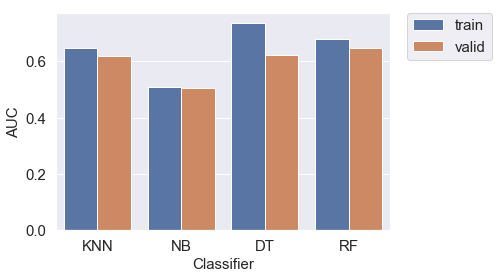

In [62]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

The next step is to try to improve the models. 

## Model Selection: Learning Curve

We can diagnose how our models are doing by plotting a learning curve. In this section, we will make use of the learning curve code from scikit-learn's website with a small change of plotting the AUC instead of accuracy. http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html. 

In [63]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

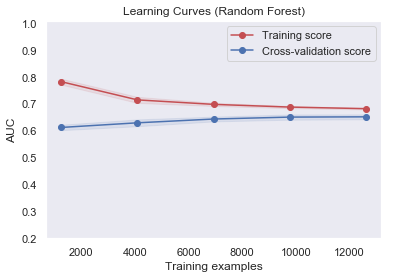

In [64]:
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 6, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In the case of random forest, we can see the training and validation scores are similar but they both have low scores. This is called high bias and is a sign of underfitting. 

## Model Selection: Feature Importance

### Feature Importance: random forest

We can also investigate feature importance for random forest models. In this case, the feature importance shows how often a particular feature was used to split the data. In this case, we don't know if a particular feature is correlated with the positive class or negative class, but rather it is just importance for making a decision. 

In [65]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [66]:
feature_importances.head()

,importance
number_inpatient,0.300483
number_emergency,0.120202
discharge_disposition_id_22,0.089470
num_medications,0.062188
time_in_hospital,0.054703


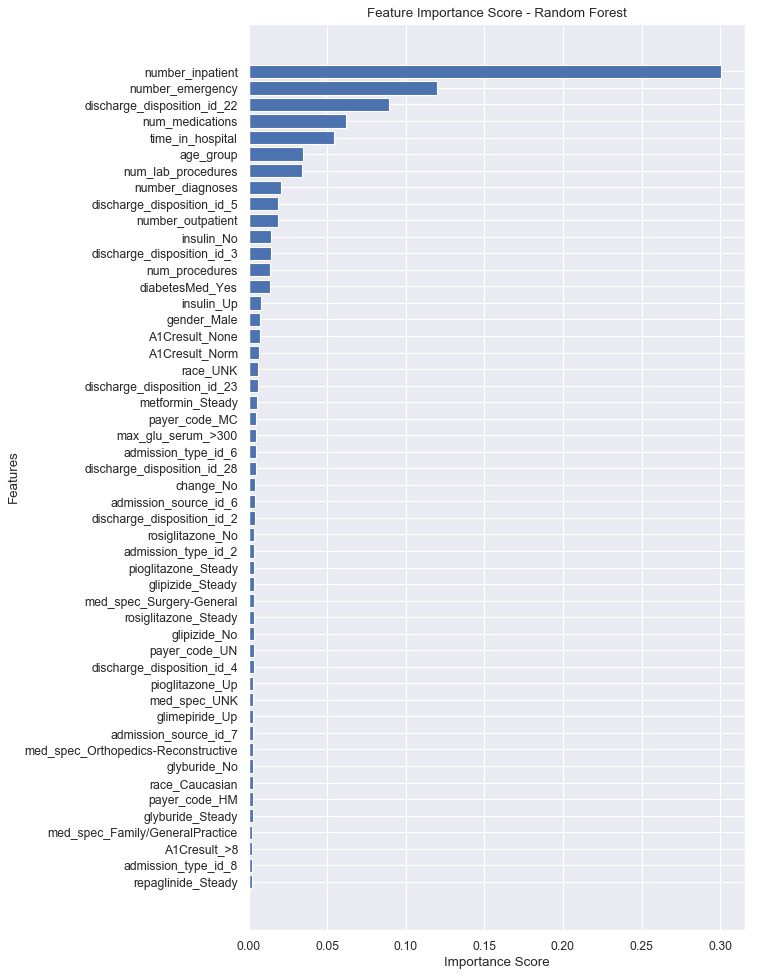

In [67]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

As you can see here, most of the important variables for random forest are continuous variables. This makes sense since you can split continuous variables more times than categorical variables. 

## Model Selection: Hyperparameter tuning

Hyperparameter tuning are essentially the design decisions that you made when you set up the machine learning model. For example, what is the maximum depth for your random forest? Each of these hyperparameters can be optimized to improve the model. 

In this section, we will only optimize the hyper parameters for stochastic gradient descent, random forest and gradient boosting classifier. We will not optimize KNN since it took a while to train. We will not optimize Logistic regression since it performs similarly to stochastic gradient descent. We will not optimize decision trees since they tend to overfit and perform worse that random forests and gradient boosting classifiers.

In [68]:
rf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Let's create a grid over a few of these (see the scikit-learn website for the descriptions). 

In [69]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(1,10,1)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(1, 10), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


we can get a list of the parameters inside a model with `get_params`. Here are the parameters in the random forest model. Wow there are so many of them! 

To use the RandomizedSearchCV function, we need something to score or evaluate a set of hyperparameters. Here we will use the auc. 

In [70]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [71]:
# create the randomized search cross-validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, scoring=auc_scoring,
                               verbose = 1, random_state = 42)

In [72]:
# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  5.6min finished


352.4141182899475


See the best parameters

In [73]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 6,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'gini'}

Let's analyze the performance of the best model compared to the baseline model.

In [74]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Baseline Random Forest')
rf_train_auc_base = roc_auc_score(y_train, y_train_preds)
rf_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(rf_train_auc_base))
print('Validation AUC:%.3f'%(rf_valid_auc_base))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(rf_train_auc))
print('Validation AUC:%.3f'%(rf_valid_auc))

Baseline Random Forest
Training AUC:0.681
Validation AUC:0.648
Optimized Random Forest
Training AUC:0.724
Validation AUC:0.661


## Model Selection: Best Classifier

 Here we will chose the gradient boosting classifier since it has the best AUC on the validation set. You won't want to train your best classifier every time you want to run new predictions. Therefore, we need to save the classifier. We will use the package pickle.

In [75]:
pickle.dump(rf_random.best_estimator_, open('best_classifier.pkl', 'wb'),protocol = 4)

# Model Evaluation

Now that we have selected our best model. Let's evaluate the performance of the test set.

In [76]:
X_test = df_test[col2use].values
y_test = df_test['OUTPUT_LABEL'].values

scaler = pickle.load(open('scaler.sav', 'rb'))
X_test_tf = scaler.transform(X_test)

C:\Users\Shreya Patil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [77]:
best_model = pickle.load(open('best_classifier.pkl','rb'))


In [78]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]


In [79]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.724
accuracy:0.660
recall:0.627
precision:0.672
specificity:0.694
prevalence:0.500
 
Validation:
AUC:0.661
accuracy:0.631
recall:0.600
precision:0.173
specificity:0.635
prevalence:0.113
 
Test:
AUC:0.660
accuracy:0.629
recall:0.608
precision:0.180
specificity:0.631
prevalence:0.117
 


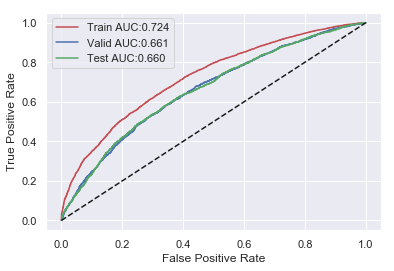

In [80]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
# read the file and create a pandas dataframe
data = pd.read_csv('diabetic_data.csv')

In [83]:
# take a first look at the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [84]:
# first 5 rows of data
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Text(0, 0.5, 'Count')

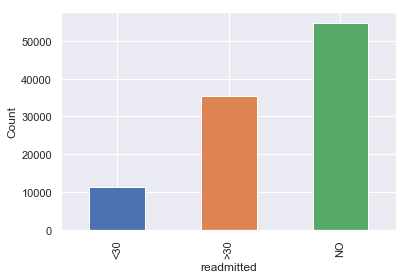

In [85]:
# the response variable 'readmitted' in the original dataset contains three categories.
# 11% of patients were readmitted within 30 days (<30)
# 35% of patients were readmitted after 30 days (>30)
# 54% of patients were never readmitted (NO)
data.groupby('readmitted').size().plot(kind='bar')
plt.ylabel('Count')

In [86]:
# recode the response variable so that it becomes a binary classification task.
# '0' means no readmission
# '1' means readmission no matter how many days after being discharged
data['readmitted'] = pd.Series([0 if val == 'NO' else 1 for val in data['readmitted']])
data_origin = data

Text(0, 0.5, 'Count')

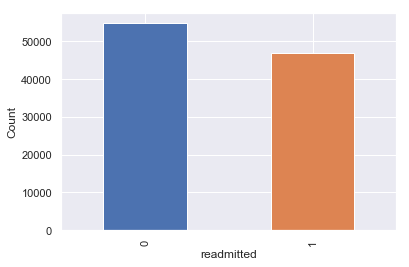

In [87]:
# plot 'readmitted' again to see the change
data.groupby('readmitted').size().plot(kind='bar')
plt.ylabel('Count')

# Feature Engineering and EDA
Explore data analysis on each feature and decide how to deal with them.

In [88]:
# remove irrelevant features
data.drop(['encounter_id', 'patient_nbr', 'payer_code'], axis=1, inplace=True)

In [89]:
# check NA in 'weight'
data[data['weight'] == '?'].shape[0] * 1.0 / data.shape[0]

0.9685847925633315

In [90]:
# check NA in 'medical_specialty'
data[data['medical_specialty'] == '?'].shape[0] * 1.0 / data.shape[0]

0.49082208203132677

In [91]:
# remove 'weight' and 'medical_specialty' because it's hard to do imputation on them
data.drop(['weight', 'medical_specialty'], axis=1, inplace=True)

In [92]:
# remove rows that have NA in 'race', 'diag_1', 'diag_2', or 'diag_3'
# remove rows that have invalid values in 'gender'
data = data[data['race'] != '?']
data = data[data['diag_1'] != '?']
data = data[data['diag_2'] != '?']
data = data[data['diag_3'] != '?']
data = data[data['gender'] != 'Unknown/Invalid']

Text(0, 0.5, 'Count')

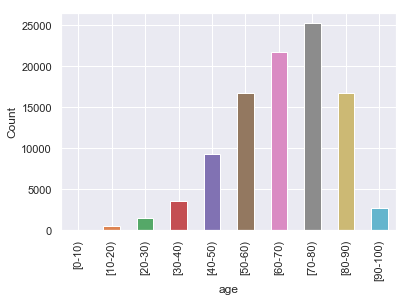

In [93]:
# check 'age' feature
data.groupby('age').size().plot(kind='bar')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

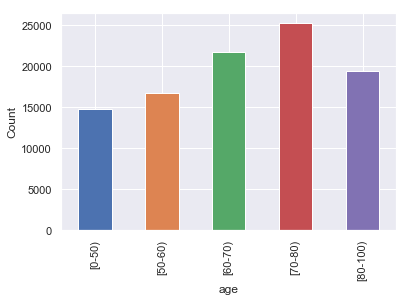

In [94]:
# Recategorize 'age' so that the population is more evenly distributed
data['age'] = pd.Series(['[0-50)' if val in ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)'] else val 
                         for val in data['age']], index=data.index)
data['age'] = pd.Series(['[80-100)' if val in ['[80-90)', '[90-100)'] else val 
                         for val in data['age']], index=data.index)

data.groupby('age').size().plot(kind='bar')
plt.ylabel('Count')

In [95]:
data = data.loc[~data.discharge_disposition_id.isin([11,13,14,18,19,20,21,25,26])]

In [96]:
data = data.loc[~data.admission_type_id.isin([5,6,8])]

In [97]:
data = data.loc[~data.admission_source_id.isin([9,15,17,20,21,26])]

In [98]:
# original 'discharge_disposition_id' contains 28 levels
# reduce 'discharge_disposition_id' levels into 2 categories
# discharge_disposition_id = 1 corresponds to 'Discharge Home'
data['discharge_disposition_id'] = pd.Series(['discharge_disposition_id-Home' if val == 1 else 'discharge_disposition_id-Other' if val == 7 or val == 9 or val == 10 or val == 12 else 'discharge_disposition_id-Discharged/Transferred' 
                                              for val in data['discharge_disposition_id']], index=data.index)

In [99]:
# original 'admission_source_id' contains 25 levels
# reduce 'admission_source_id' into 3 categories
data['admission_source_id'] = pd.Series(['admission_source_id-Emergency Room' if val == 7 or val == 10 else 'admission_source_id-Referral' if val == 1 or val == 2 or val == 3 else 'admission_source_id-Transfer' if val == 4 or val == 5 or val == 6 or val == 18 or val == 22 or val == 25 or val == 26 else 'admission_source_id-Other source' 
                                              for val in data['admission_source_id']], index=data.index)

In [100]:
# original 'admission_type_id' contains 8 levels
# reduce 'admission_type_id' into 2 categories
data['admission_type_id'] = pd.Series(['admission_type_id-Emergency' if val == 1 or val == 2 else 'admission_type_id-Other type' 
                                              for val in data['admission_type_id']], index=data.index)

Text(0, 0.5, 'Count')

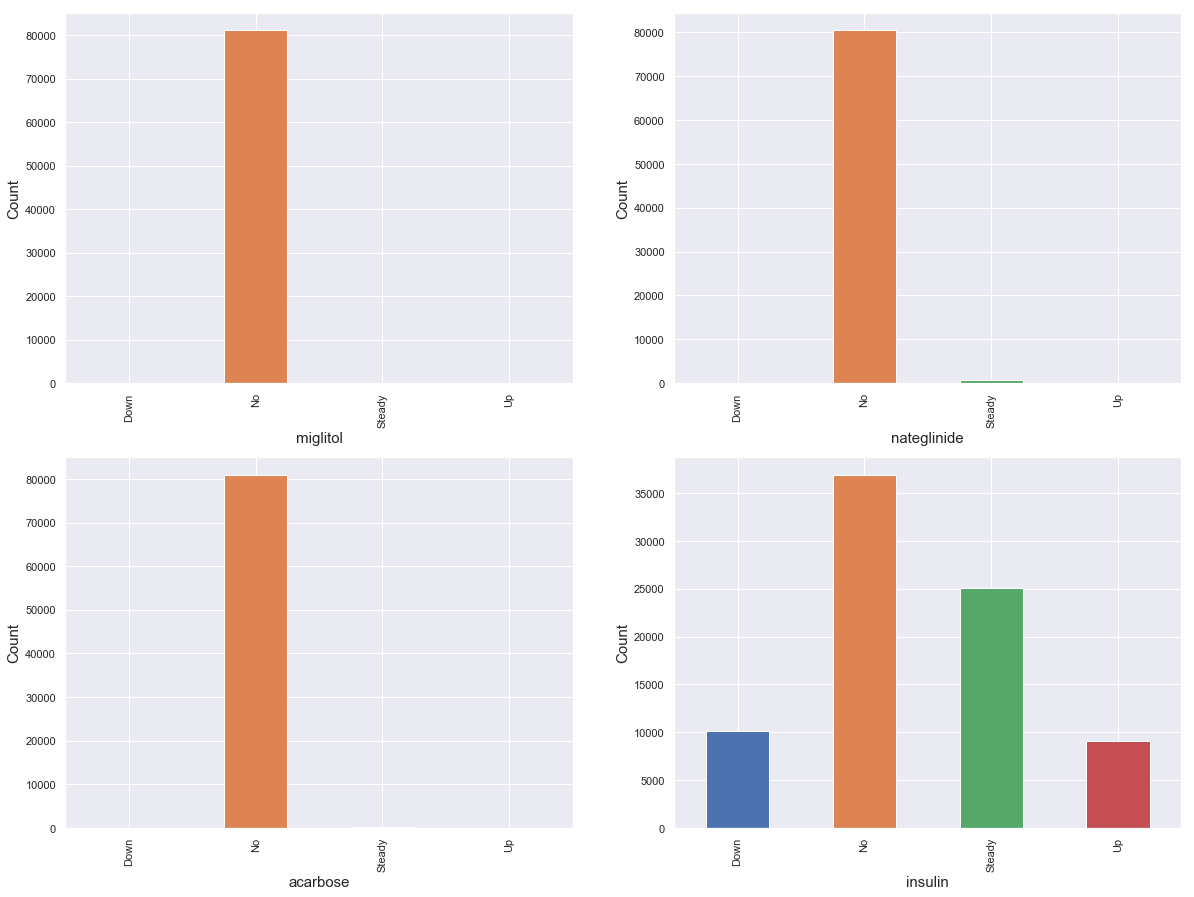

In [101]:
# compare diabetes medications 'miglitol', 'nateglinide' and 'acarbose' with 'insulin', as an example
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(221)
ax1 = data.groupby('miglitol').size().plot(kind='bar')
plt.xlabel('miglitol', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax2 = fig.add_subplot(222)
ax2 = data.groupby('nateglinide').size().plot(kind='bar')
plt.xlabel('nateglinide', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax3 = fig.add_subplot(223)
ax3 = data.groupby('acarbose').size().plot(kind='bar')
plt.xlabel('acarbose', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax4 = fig.add_subplot(224)
ax4 = data.groupby('insulin').size().plot(kind='bar')
plt.xlabel('insulin', fontsize=15)
plt.ylabel('Count', fontsize=15)

In [102]:
# keep only 'insulin' and remove the other 22 diabetes medications
data.drop(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
           'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
           'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 
           'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
           'metformin-rosiglitazone', 'metformin-pioglitazone'], axis=1, inplace=True)

In [103]:
# denote 'diag_1' as '1' if it relates to diabetes and '0' if it's not
# remove 'diag_2' and 'diag_3'
data['diag_1'] = pd.Series([1 if val.startswith('250') else 0 for val in data['diag_1']], index=data.index)
data.drop(['diag_2', 'diag_3'], axis=1, inplace=True)

In [104]:
data.shape

(81162, 21)

In [105]:
# one-hot-encoding on categorical features
# convert nominal values to dummy values

df_age = pd.get_dummies(data['age'])
df_race = pd.get_dummies(data['race'])
df_gender = pd.get_dummies(data['gender'])
df_max_glu_serum = pd.get_dummies(data['max_glu_serum'])
df_A1Cresult = pd.get_dummies(data['A1Cresult'])
df_insulin = pd.get_dummies(data['insulin'])
df_change = pd.get_dummies(data['change'])
df_diabetesMed = pd.get_dummies(data['diabetesMed'])
df_discharge_disposition_id = pd.get_dummies(data['discharge_disposition_id'])
df_admission_source_id = pd.get_dummies(data['admission_source_id'])
df_admission_type_id = pd.get_dummies(data['admission_type_id'])


In [106]:
data = pd.concat([data, df_age, df_race, df_gender, df_max_glu_serum, df_A1Cresult, 
                  df_insulin, df_change, df_diabetesMed, df_discharge_disposition_id, 
                  df_admission_source_id, df_admission_type_id], axis=1)
data.drop(['age', 'race', 'gender', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 
                  'diabetesMed', 'discharge_disposition_id', 'admission_source_id', 
                  'admission_type_id'], axis=1, inplace=True)

In [107]:
# apply square root transformation on right skewed count data to reduce the effects of extreme values.
# here log transformation is not appropriate because the data is Poisson distributed and contains many zero values.
data['number_outpatient'] = data['number_outpatient'].apply(lambda x: np.sqrt(x + 0.5))
data['number_emergency'] = data['number_emergency'].apply(lambda x: np.sqrt(x + 0.5))
data['number_inpatient'] = data['number_inpatient'].apply(lambda x: np.sqrt(x + 0.5))

In [108]:
# feature scaling, features are standardized to have zero mean and unit variance
feature_scale_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                      'number_diagnoses', 'number_inpatient', 'number_emergency', 'number_outpatient']

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data[feature_scale_cols])
data_scaler = scaler.transform(data[feature_scale_cols])

data_scaler_df = pd.DataFrame(data=data_scaler, columns=feature_scale_cols, index=data.index)
data.drop(feature_scale_cols, axis=1, inplace=True)
data = pd.concat([data, data_scaler_df], axis=1)

C:\Users\Shreya Patil\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Shreya Patil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


# Data Preparation Summary
1. Remove NA in 'race', 'gender', 'diag_1', 'diag_2', and 'diag_3'
2. Remove 29 features in total: 'encounter_id', 'patient_nbr', 'payer_code', 'weight', 'medical_specialty', 'diag_2', 'diag_3', and 22 features for medications, including 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', and 'metformin-pioglitazone'
2. Recategorize 'age' feature
3. Reduce levels in 'discharge_disposition_id', 'admission_source_id', and 'admission_type_id'
4. One-hot-encode on categorical data
5. Square root transform on right skewed count data
6. Apply feature standardizing on numerical data

# Feature Importance
Evaluate the importance of different features by using emsemble method.

In [109]:
# create X (features) and y (response)
X = data.drop(['readmitted'], axis=1)
y = data['readmitted']

In [110]:
listnew = []
count = 0
for col in X.columns: 
    listnew.append(col)
    count = count + 1
print(listnew)
print(count)

['diag_1', '[0-50)', '[50-60)', '[60-70)', '[70-80)', '[80-100)', 'AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other', 'Female', 'Male', '>200', '>300', 'None', 'Norm', '>7', '>8', 'None', 'Norm', 'Down', 'No', 'Steady', 'Up', 'Ch', 'No', 'No', 'Yes', 'discharge_disposition_id-Discharged/Transferred', 'discharge_disposition_id-Home', 'discharge_disposition_id-Other', 'admission_source_id-Emergency Room', 'admission_source_id-Other source', 'admission_source_id-Referral', 'admission_source_id-Transfer', 'admission_type_id-Emergency', 'admission_type_id-Other type', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'number_inpatient', 'number_emergency', 'number_outpatient']
46


In [111]:
# split X and y into cross-validation (75%) and testing (25%) data sets
from sklearn.model_selection import train_test_split
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.25)

In [112]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_cv,y_cv)

y_pred=clf.predict(X_test)

In [113]:
y_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [114]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20291 entries, 2067 to 9296
Data columns (total 46 columns):
diag_1                                             20291 non-null int64
[0-50)                                             20291 non-null uint8
[50-60)                                            20291 non-null uint8
[60-70)                                            20291 non-null uint8
[70-80)                                            20291 non-null uint8
[80-100)                                           20291 non-null uint8
AfricanAmerican                                    20291 non-null uint8
Asian                                              20291 non-null uint8
Caucasian                                          20291 non-null uint8
Hispanic                                           20291 non-null uint8
Other                                              20291 non-null uint8
Female                                             20291 non-null uint8
Male                     

In [115]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6101227145039673


In [116]:
output = clf.predict([[1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1, 0,1,0, 1,0,0,0, 0,1, 4,34,3,17,6,0,1,2]])
if output == 1:
    print("<30")
else:
    print("NO")

<30


In [117]:
from tkinter import *
from tkinter.messagebox import *
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
import tkinter.ttk as ttk
import csv


root = Tk()
root.geometry('800x700')
root.title("Diabetes Patient Readmission Prediction")

label0 = Label(root, text="Patient Data Entry",width=20,font=("bold", 20))
label0.grid(row = 1 , column = 1)

label1 = Label(root, text="Race",width=20,font=("bold", 10))
label1.grid(row = 5 , column = 0)

list1 =['Caucasian','AfricanAmerican','Hispanic','Asian','Other']
list_1 =['Caucasian','AfricanAmerican','Hispanic','Asian','Other']
c1=StringVar()
droplist=OptionMenu(root,c1, *list1)
droplist.config(width=15)
c1.set('Select')
droplist.grid(row = 5 , column = 1)

label2 = Label(root, text="Gender",width=20,font=("bold", 10))
label2.grid(row = 6 , column = 0)
list_2 =['Male','Female']
var1 = StringVar()
n1 = "Male"
n2 = "Female"
Radiobutton(root, text=n1, variable=var1, value=n1).grid(row = 6 , column = 1)
Radiobutton(root, text=n2, variable=var1, value=n2).grid(row = 6 , column = 2)

label3 = Label(root, text="Age",width=20,font=("bold", 10))
label3.grid(row = 7 , column = 0)
list2 =['[0-50)' ,'[50-60)' ,'[60-70)','[70-80)', '[80-100)']
list_3 =['[0-50)' ,'[50-60)' ,'[60-70)','[70-80)', '[80-100)']
c2=StringVar()
droplist=OptionMenu(root,c2, *list2)
droplist.config(width=15)
c2.set('Select')
droplist.grid(row = 7 , column = 1)

label4 = Label(root, text="Admission Type id",width=20,font=("bold", 10))
label4.grid(row = 9 , column = 0)
list3 = ['Emergency','Other_type']
list_4 = ['Emergency','Other_type']
c3=StringVar()
droplist=OptionMenu(root,c3, *list3)
droplist.config(width=15)
c3.set('Select')
droplist.grid(row = 9 , column = 1)

label5 = Label(root, text="Discharge Disposition id",width=20,font=("bold", 10))
label5.grid(row = 10 , column = 0)
list4 = ['Home', 'Discharged/Transferred', 'Other']
list_5 = ['Home', 'Discharged/Transferred', 'Other']
c4=StringVar()
droplist=OptionMenu(root,c4, *list4)
droplist.config(width=15)
c4.set('Select')
droplist.grid(row = 10 , column = 1)

label6 = Label(root, text="Admission Source id",width=20,font=("bold", 10))
label6.grid(row = 11 , column = 0)
list5 =['Emergency_Room','Other_source','Referral', 'Transfer']
list_6 =['Emergency_Room','Other_source','Referral', 'Transfer']
c5=StringVar()
droplist=OptionMenu(root,c5, *list5)
droplist.config(width=15)
c5.set('Select')
droplist.grid(row = 11 , column = 1)

label7 = Label(root, text="Time in Hospital",width=20,font=("bold", 10))
label7.grid(row = 12 , column = 0)
list6 =[1,2,3,4,5,6,7,8,9,10,11,12,13,14]
c6=StringVar()
droplist=OptionMenu(root,c6, *list6)
droplist.config(width=15)
c6.set('Select')
droplist.grid(row = 12 , column = 1)

label8 = Label(root, text="Number of Lab Procedures",width=20,font=("bold", 10))
label8.grid(row =15 , column = 0)

entry1 = Entry(root, width=15)
entry1.grid(row = 15 , column = 1)

label9 = Label(root, text="Number of Procedures",width=20,font=("bold", 10))
label9.grid(row = 16 , column = 0)
list7 =[0,1,2,3,4,5,6]
c7=StringVar()
droplist=OptionMenu(root,c7, *list7)
droplist.config(width=15)
c7.set('Select')
droplist.grid(row = 16 , column = 1)

label10 = Label(root, text="Number of Medication",width=20,font=("bold", 10))
label10.grid(row =17 , column = 0)

entry2 = Entry(root, width=15)
entry2.grid(row = 17 , column = 1)

label11 = Label(root, text="Number of Outpatient",width=20,font=("bold", 10))
label11.grid(row =18 , column = 0)

entry3 = Entry(root, width=15)
entry3.grid(row = 18 , column = 1)

label12 = Label(root, text="Number of Emergency",width=20,font=("bold", 10))
label12.grid(row =19 , column = 0)

entry4 = Entry(root, width=15)
entry4.grid(row = 19 , column = 1)

label13 = Label(root, text="Number of Inpatient",width=20,font=("bold", 10))
label13.grid(row = 20 , column = 0)
list8 =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21]
c8=StringVar()
droplist=OptionMenu(root,c8, *list8)
droplist.config(width=15)
c8.set('Select')
droplist.grid(row = 20 , column = 1)

label14 = Label(root, text="diagnosis_1",width=20,font=("bold", 10))
label14.grid(row =21 , column = 0)

entry5 = Entry(root, width=15)
entry5.grid(row = 21 , column = 1)

label15 = Label(root, text="Number of Diagnosis",width=20,font=("bold", 10))
label15.grid(row = 24 , column = 0)
list9 =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
c9=StringVar()
droplist=OptionMenu(root,c9, *list9)
droplist.config(width=15)
c9.set('Select')
droplist.grid(row = 24 , column = 1)

label16 = Label(root, text="max_glu_serum",width=20,font=("bold", 10))
label16.grid(row = 25 , column = 0)
list10 =['None', '>300', 'Norm', '>200']
list_11 =['None', '>300', 'Norm', '>200']
c10=StringVar()
droplist=OptionMenu(root,c10, *list10)
droplist.config(width=15)
c10.set('Select')
droplist.grid(row = 25 , column = 1)

label17 = Label(root, text="A1Cresult",width=20,font=("bold", 10))
label17.grid(row = 26 , column = 0)
list11 =['None', '>7', '>8', 'Norm']
list_12 =['None', '>7', '>8', 'Norm']
c11=StringVar()
droplist=OptionMenu(root,c11, *list11)
droplist.config(width=15)
c11.set('Select')
droplist.grid(row = 26 , column = 1)

label18 = Label(root, text="Insulin",width=20,font=("bold", 10))
label18.grid(row = 44 , column = 0)
list12 =['No','Steady','Up','Down']
list_13 =['No','Steady','Up','Down']
c12=StringVar()
droplist=OptionMenu(root,c12, *list12)
droplist.config(width=15)
c12.set('Select')
droplist.grid(row = 44 , column = 1)

label19 = Label(root, text="Change",width=20,font=("bold", 10))
label19.grid(row = 50 , column = 0)
list_14 =['Ch','No']
var2 = StringVar()
n3 = "Ch"
n4 = "No"
Radiobutton(root, text=n3, variable=var2, value=n3).grid(row = 50 , column = 1)
Radiobutton(root, text=n4, variable=var2, value=n4).grid(row = 50 , column = 2)

label20 = Label(root, text="Diabetes Med",width=20,font=("bold", 10))
label20.grid(row = 51 , column = 0)
list_15 =['Yes','No']
var3 = StringVar()
n5 = "Yes"
n6 = "No"
Radiobutton(root, text=n5, variable=var3, value=n5).grid(row = 51 , column = 1)
Radiobutton(root, text=n6, variable=var3, value=n6).grid(row = 51 , column = 2)


def show_answer():
    value1=c1.get()
    value2=var1.get()
    value3=c2.get()
    value4=c3.get()
    value5=c4.get()
    value6=c5.get()
    value7=c6.get()
    value8=entry1.get()
    value9=c7.get()
    value10=entry2.get()
    value11=entry3.get()
    value12=entry4.get()
    value13=c8.get()
    value14=entry5.get()
    value15=c9.get()
    value16=c10.get()
    value17=c11.get()
    value18=c12.get()
    value19=var2.get()
    value20=var3.get()
    
    for i in range(len(list_1)):
        if list_1[i] == value1:
            list_1[i] = 1
        else:
            list_1[i] = 0
    print(list_1)
    for i in range(len(list_2)):
        if list_2[i] == value2:
            list_2[i] = 1
        else:
            list_2[i] = 0
    print(list_2)
    for i in range(len(list_3)):
        if list_3[i] == value3:
            list_3[i] = 1
        else:
            list_3[i] = 0
    print(list_3)
    for i in range(len(list_4)):
        if list_4[i] == value4:
            list_4[i] = 1
        else:
            list_4[i] = 0
    print(list_4)
    for i in range(len(list_5)):
        if list_5[i] == value5:
            list_5[i] = 1
        else:
            list_5[i] = 0
    print(list_5)
    for i in range(len(list_6)):
        if list_6[i] == value6:
            list_6[i] = 1
        else:
            list_6[i] = 0
    print(list_6)
    for i in range(len(list_11)):
        if list_11[i] == value16:
            list_11[i] = 1
        else:
            list_11[i] = 0
    print(list_11)
    for i in range(len(list_12)):
        if list_12[i] == value17:
            list_12[i] = 1
        else:
            list_12[i] = 0
    print(list_12)
    for i in range(len(list_13)):
        if list_13[i] == value18:
            list_13[i] = 1
        else:
            list_13[i] = 0
    print(list_13)
    for i in range(len(list_14)):
        if list_14[i] == value19:
            list_14[i] = 1
        else:
            list_14[i] = 0
    print(list_14)
    for i in range(len(list_15)):
        if list_15[i] == value20:
            list_15[i] = 1
        else:
            list_15[i] = 0
    print(list_15)
    
 
    list16=[]
    list16.append(value14)
    for i in list_3 : 
        list16.append(i)
    #list10.append(list_3)
    for i in list_1 : 
        list16.append(i)
    #list10.append(list_1)
    for i in list_2 : 
        list16.append(i)
    #list10.append(list_2)
    for i in list_11 : 
        list16.append(i)
    #list10.append(list_11)
    for i in list_12 : 
        list16.append(i)
    #list10.append(list_12)
    for i in list_13 : 
        list16.append(i)
    #list10.append(list_13)
    for i in list_14 : 
        list16.append(i)
    #list10.append(list_14)
    for i in list_15 : 
        list16.append(i)
    #list10.append(list_15)
    for i in list_5 : 
        list16.append(i)
    #list10.append(list_5)
    for i in list_6 : 
        list16.append(i)
    #list10.append(list_6)
    for i in list_4 : 
        list16.append(i)
    #list10.append(list_4)

    list16.append(value7)
    list16.append(value8)
    list16.append(value9)
    list16.append(value10)
    list16.append(value15)
    list16.append(value13)
    list16.append(value12)
    list16.append(value11)
    
    print(list16)
    ans = list16
    output = clf.predict([ans])
    if output == 1:
        print("<30")
        opt = "<30"
    else:
        print("NO")
        opt = "NO"
    entry6.delete(0,END)
    entry6.insert(0,opt)




Button(root, text='Predict',command=show_answer, width=20,bg='brown',fg='white').grid(row = 56 , column = 0)
#Button(root, text='ID Mapping',width=20,bg='brown',fg='white', command =new_winF).grid(row = 20 , column = 1)
Button(root, text='Quit', command=root.destroy, width=20,bg='brown',fg='white').grid(row = 56, column = 2)

label21 = Label(root, text="Selected Fields",width = 20,font=("bold", 12))
label21.grid(row = 60 , column = 0)

entry6 = Entry(root,width = 60)
entry6.grid(row = 60 , column = 1)

root.mainloop()

In [118]:
import tkinter
import csv

root = tkinter.Tk()

# open file
with open("IDs_mapping2.csv", newline = "") as file:
   reader = csv.reader(file)

   # r and c tell us where to grid the labels
   r = 0
   for col in reader:
      c = 0
      for row in col:
         # i've added some styling
        if c%2 == 0:
            label = tkinter.Label(root, width = 20, height = 1, \
                               text = row, relief = tkinter.RIDGE)
            label.grid(row = r, column = c)
        else :
            if c == 1:
                label = tkinter.Label(root, width = 15, height = 1, \
                                   text = row, relief = tkinter.RIDGE)
                label.grid(row = r, column = c)
            elif c == 5:
                label = tkinter.Label(root, width = 50, height = 1, \
                                   text = row, relief = tkinter.RIDGE)
                label.grid(row = r, column = c)
            else:
                label = tkinter.Label(root, width = 85, height = 1, \
                                   text = row, relief = tkinter.RIDGE)
                label.grid(row = r, column = c)
        c += 1
      r += 1

root.mainloop()

C:\Users\Shreya Patil\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Top 6 features are: 
num_lab_procedures
num_medications
time_in_hospital
num_procedures
number_diagnoses
number_inpatient


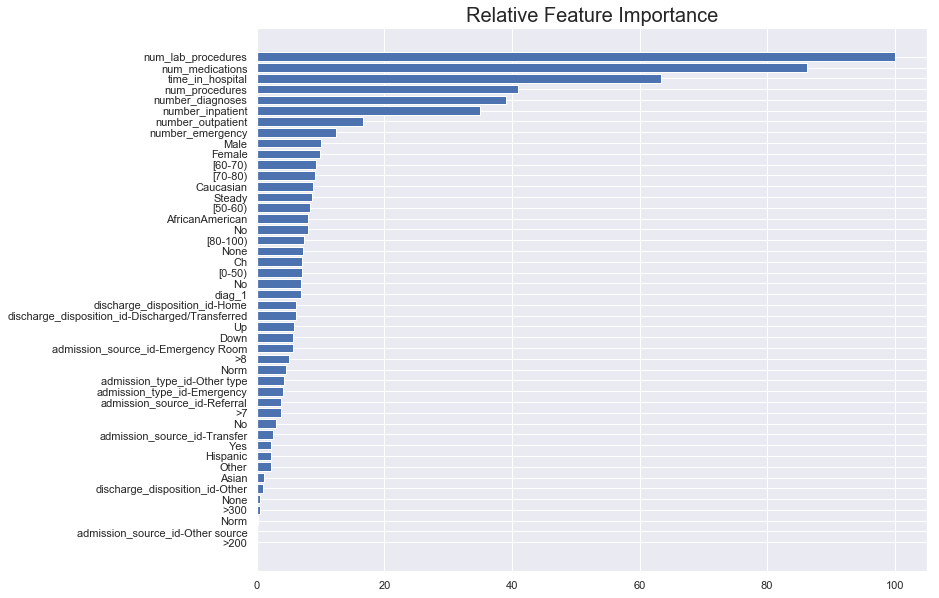

In [119]:
# fit Random Forest model to the cross-validation data
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_cv, y_cv)
importances = forest.feature_importances_

# make importance relative to the max importance
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
feature_names = list(X_cv.columns.values)
feature_names_sort = [feature_names[indice] for indice in sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5
print ('Top 6 features are: ')
for feature in feature_names_sort[::-1][:6]:
    print (feature)

# plot the result
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names_sort)
plt.title('Relative Feature Importance', fontsize=20)
plt.show()

# Conclusion

Through this project, we created a binary classifier to predict the probability that a patient with diabetes would be readmitted to the hospital within 30 days. On held out test data, our best model had an AUC of of 0.67. Using this model, we are able to catch 58% of the readmissions from our model that performs approximately 1.5 times better than randomly selecting patients. 